In [147]:
#from flow_utils import *
from os import listdir
import pandas as pd
import numpy as np
from natsort import natsorted
from glob import glob
import matplotlib
import matplotlib.pyplot as plt 

%matplotlib inline
matplotlib.rc("figure", dpi=300)

In [148]:
# directory where mean files generated by MATLAB scripts are
data_prefix = "./means/";

# the name of the files generated by MATLAB changed to -> "mb or sec"_"replicateName"_"r,g,b".csv
# example: sec_s1_r.csv or mb_s2_g.csv
filesg = natsorted(glob(data_prefix + "m*g.csv"))
filesb = natsorted(glob(data_prefix + "m*b.csv"))
filesr = natsorted(glob(data_prefix + "m*r.csv"))
filesg,filesb, filesr

(['./means/mb_main_g.csv', './means/mb_s1_g.csv', './means/mb_s2_g.csv'],
 ['./means/mb_main_b.csv', './means/mb_s1_b.csv', './means/mb_s2_b.csv'],
 ['./means/mb_main_r.csv', './means/mb_s1_r.csv', './means/mb_s2_r.csv'])

In [149]:
#create data frames for each channel (RGB)
dfsg = []
dfsb = []
dfsr = []
for f in filesg:
    dfsg.append(pd.read_csv(f, header=None).T.values.tolist())

for f in filesb:
    dfsb.append(pd.read_csv(f, header=None).T.values.tolist())
    
for f in filesr:
    dfsr.append(pd.read_csv(f, header=None).T.values.tolist())

if len(dfsg)!=len(dfsb):
    print('ERROR! You need the same number of files for green and blue pixels!!')
    
len(dfsg), len(dfsb), len(dfsr)

(3, 3, 3)

In [150]:
#number of values = number of co-centric lines
len(dfsg[0][0]), len(dfsb[0][0]), len(dfsr[0][0])

(200, 200, 200)

In [151]:
#take window = 3 for smoothing for green channel
smoothsg = []
for df in dfsg:
    mean = df[0]
    smooth = []
    mm = np.min(mean[:50])
    for it in range(len(mean)-2):
        temp = ((mean[it]+ mean[it+1]+ mean[it+2])/3)-(mm*1.5)
        if temp>=0:
            smooth.append(temp)
        else:
            smooth.append(0)
    smoothsg.append(smooth)

In [152]:
#take window = 3 for smoothing for red channel
smoothsr = []
for df in dfsr:
    mean = df[0]
    smooth = []
    mm = np.min(mean[:100])
    for it in range(len(mean)-2):
        temp = ((mean[it]+ mean[it+1]+ mean[it+2])/3)-(mm*0.9)
        if temp>=0:
            smooth.append(temp)
        else:
            smooth.append(0)
    smoothsr.append(smooth)

In [153]:
#take window = 10 for smoothing for blue channel (more noisy)
#calculate also the rate of change (derivative) of the profile (delta)
smoothsb = []
deltas=[]
for df in dfsb:
    mean = df[0]
    smooth = []
    delta=[]
    mm = np.min(mean[100:])
    for it in range(len(mean)-2):
        temp = (sum(mean[it:it+10])/10)-(mm*0.9)
        try:
            t_delta = (mean[it+17]-mean[it])/17
            delta.append(t_delta)
        except:
            pass
        if temp>=0:
            smooth.append(temp)
        else:
            smooth.append(0)
    deltas.append(delta)
    smoothsb.append(smooth)

In [154]:
#index of the maximum value for green channel = activated cells
#not used anymore -> using derivative

#these values are indexes not the pixel values
maxs=[]
for ms in smoothsg:
    idx=ms.index(np.max(ms))
    maxs.append(idx)
maxs

[115, 82, 114]

In [155]:
# index of the array where the function (blue channel profile) is the most 
# negative (decreases the fastest = interface between sender and receiver cells)

#these values are indexes not the pixel values
maxs=[]
for ms in deltas:
    idx=ms.index(np.min(ms))
    maxs.append(idx)
maxs

[114, 77, 117]

In [156]:
# centering all profiles using the interface of receiver and sender cells using the indexes in from above
# so that they are always in the center of the final plot
new_meansg=[]
new_meansb=[]
new_meansr=[]
for i,v in enumerate(smoothsg):
    m = maxs[i]
    new_meansg.append(v[m-min(maxs):m] + v[m:m+80])
    dfb = smoothsb[i]
    new_meansb.append(dfb[m-min(maxs):m] + dfb[m:m+80])
    dfr = smoothsr[i]
    new_meansr.append(dfr[m-min(maxs):m] + dfr[m:m+80])

In [157]:
len(new_meansg[2]), len(new_meansb[2]), len(new_meansg[1]), len(new_meansb[1])

(157, 157, 157, 157)

In [158]:
# calculating distance in uM. 
# each pixel = 0.8788 uM
xs = []
for j,n in enumerate(new_meansg):
    x = [0]*len(n) 
    temp_m = min(maxs)
    x[temp_m] = 0
    for i in range(temp_m+1,len(n)):
        rel_dist = i - temp_m
        x[i] = 0.8788*10*rel_dist
    for i in range(temp_m-1, -1, -1):
        rel_dist = i - temp_m
        x[i] = 0.8788*10*rel_dist
    xs.append(x)

In [159]:
#Get max, min and mean of BFP data

mean_bs = []
for b in new_meansb:
    temp = np.array(b)
    temp = temp/np.max(temp)
    mean_bs.append(temp)
    
smooth_mean_b = np.mean(np.array(mean_bs), axis=0)
smooth_min_b = np.min(np.array(mean_bs), axis=0)
smooth_max_b = np.max(np.array(mean_bs), axis=0)

In [160]:
#Get max, min and mean of RFP data

mean_rs = []
for r in new_meansr:
    temp = np.array(r)
    temp = temp/np.max(temp)
    mean_rs.append(temp)
    
smooth_mean_r = np.mean(np.array(mean_rs), axis=0)
smooth_min_r = np.min(np.array(mean_rs), axis=0)
smooth_max_r = np.max(np.array(mean_rs), axis=0)

In [161]:
#Get max, min and mean of GFP data

mean_gs = []
for g in new_meansg:
    temp = np.array(g)
    temp = temp/np.max(temp)
    mean_gs.append(temp)
    
smooth_mean_g = np.mean(np.array(mean_gs), axis=0)
smooth_min_g = np.min(np.array(mean_gs), axis=0)
smooth_max_g = np.max(np.array(mean_gs), axis=0)

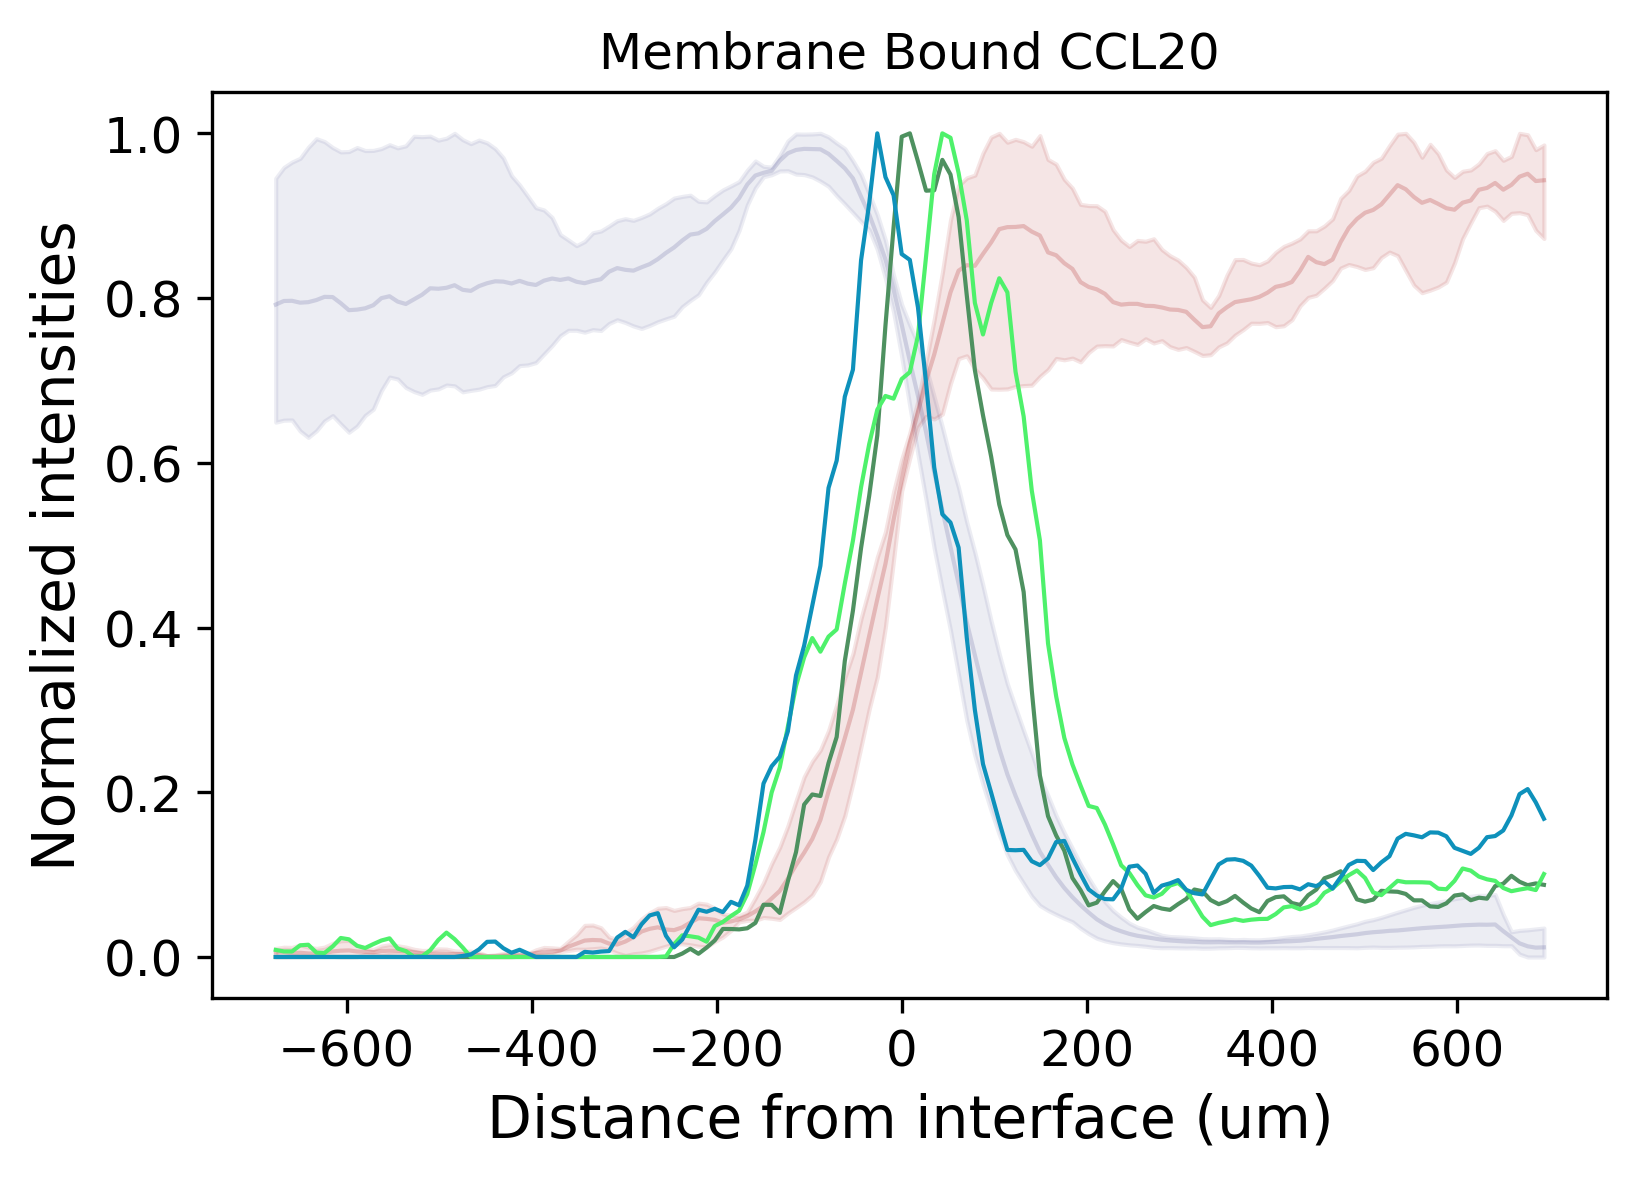

In [162]:
plt.fill_between(xs[0],smooth_min_b,smooth_max_b, color='#4e4f91', alpha=0.1)
plt.plot(xs[0],smooth_mean_b, color='#4e4f91', alpha=0.2, linewidth=1.0)

plt.fill_between(xs[0],smooth_min_r,smooth_max_r, color='#A00000', alpha=0.1)
plt.plot(xs[0],smooth_mean_r, color='#A00000', alpha=0.2, linewidth=1.0)

#plt.fill_between(xs[0],smooth_min_g,smooth_max_g, color='#4e916b', alpha=0.2)
#plt.plot(xs[0],smooth_mean_g, color='#4e916b', alpha=0.99)

plt.plot(xs[0][:len(new_meansg[0])],new_meansg[0]/np.max(new_meansg[0]), color='#4e9160', linewidth=1.0, linestyle='-', label="S3")
plt.plot(xs[1][:len(new_meansg[1])],new_meansg[1]/np.max(new_meansg[1]), color='#4ef16b', linewidth=1.0, linestyle='-', label="Main")
plt.plot(xs[2][:len(new_meansg[2])],new_meansg[2]/np.max(new_meansg[2]), color='#0e91bb', linewidth=1.0, linestyle='-', label="S1")
if len(new_meansg)>3:
    plt.plot(xs[3][:len(new_meansg[3])],new_meansg[3]/np.max(new_meansg[3]), color='#9eb162', linewidth=1.0, linestyle='-', label="S2")

#plt.legend(loc="upper right")
plt.xlabel('Distance from interface (um)', fontsize=14)
plt.ylabel('Normalized intensities',  fontsize=14)
plt.title("Membrane Bound CCL20")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.savefig("./analysis_mem_shades.svg", format='svg', dpi=3600)

In [107]:
#yul=np.array([ xs[1][:len(new_meansg[1])], new_meansg[1]/np.max(new_meansg[1])])

In [108]:
#np.savetxt("data_yulin.csv", yul, delimiter=",")